In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
np.random.seed(10)

# GETTING THE DATASET
Here I download the dataset (3/4 Mb, but pandas is a bit slow to download it), delete the rows with missing values and replace the targets with a 0 and 1 instead of '<=50K', '>50K'

In [3]:
DATASET_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-country', 'Target']
df = pd.read_csv(DATASET_URL, names=columns, na_values=['?', ' ?', '? '])

In [4]:
# strip the strings
df_str = df.select_dtypes(['object'])
df[df_str.columns] = df_str.apply(lambda x: x.str.strip())
# remove missing values and duplicates
df = df.dropna()
df = df.drop_duplicates()
# map the target into {0,1}
map_targ = {
        '<=50K': 0,
        '>50K': 1
}
df['Target'] = df.iloc[:, -1].map(map_targ)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30139 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             30139 non-null  int64 
 1   Workclass       30139 non-null  object
 2   Fnlwgt          30139 non-null  int64 
 3   Education       30139 non-null  object
 4   Education-num   30139 non-null  int64 
 5   Marital-status  30139 non-null  object
 6   Occupation      30139 non-null  object
 7   Relationship    30139 non-null  object
 8   Race            30139 non-null  object
 9   Sex             30139 non-null  object
 10  Capital-gain    30139 non-null  int64 
 11  Capital-loss    30139 non-null  int64 
 12  Hours-per-week  30139 non-null  int64 
 13  Native-country  30139 non-null  object
 14  Target          30139 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
df['Target'].value_counts()

0    22633
1     7506
Name: Target, dtype: int64

In [7]:
df.head(3)

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0


# Features preparation

Extract the numerical features and scale them

In [8]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [9]:
NUMERICAL_FEATURES = ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss']

df_numerical = df[NUMERICAL_FEATURES + ['Target']].copy()

# Scale the numerical features
scaler = StandardScaler()
df_numerical[NUMERICAL_FEATURES] = scaler.fit_transform(df_numerical[NUMERICAL_FEATURES])

In [10]:
df_numerical

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target
0,0.042516,-1.062676,1.128996,0.145925,-0.218673,0
1,0.880215,-1.007829,1.128996,-0.147502,-0.218673,0
2,-0.033639,0.244669,-0.440434,-0.147502,-0.218673,0
3,1.108678,0.425206,-1.225149,-0.147502,-0.218673,0
4,-0.795183,1.406572,1.128996,-0.147502,-0.218673,0
...,...,...,...,...,...,...
32556,-0.871338,0.638926,0.736639,-0.147502,-0.218673,0
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,1
32558,1.489450,-0.358567,-0.440434,-0.147502,-0.218673,0
32559,-1.252110,0.110688,-0.440434,-0.147502,-0.218673,0


# Clustering

Imports and utility functions

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

In [12]:
CLUSTERS = [*range(2, 12)]

In [13]:
def print_metrics(X, kmeans):
    """print the metrics of the kmeans model.
    Parameters
    ----------
        X - normalized dataset
        kmeans - model.
    Prints
    ------
        K
        SSE
        Silhouette score
        Separation
    
    """
    print(f'K={len(kmeans.cluster_centers_)}')
    print('\tSSE:\t\t{}'.format(kmeans.inertia_))
    print('\tSilhouette:\t\t{}'.format(metrics.silhouette_score(X, kmeans.labels_)))
    print('\tDaviesBouldin score:\t\t{}'.format(metrics.davies_bouldin_score(X, kmeans.labels_)))

def run_kmeans(X, range_nclusters=CLUSTERS):
    '''runs kmeans for different values of k'''
    inertia, models = [], []
    for k in range_nclusters:
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

## Class 0
Compute the clusters for class $0$

In [28]:
zeroes = df_numerical[df_numerical['Target'] == 0].copy()

In [15]:
wcss_0, models_0 = run_kmeans(zeroes[NUMERICAL_FEATURES])

In [16]:
for m in models_0:
    print_metrics(zeroes[NUMERICAL_FEATURES], m)

K=2
	SSE:		63831.006741162106
	Silhouette:		0.2552998888638537
	DaviesBouldin score:		1.581301395476283
K=3
	SSE:		51503.01747275321
	Silhouette:		0.27813943678632086
	DaviesBouldin score:		1.1913434368355498
K=4
	SSE:		40636.09948004913
	Silhouette:		0.2843852517397693
	DaviesBouldin score:		1.083047950117436
K=5
	SSE:		33723.290347028604
	Silhouette:		0.29922619998416083
	DaviesBouldin score:		0.9977057657651812
K=6
	SSE:		29483.557526698864
	Silhouette:		0.3070600574999428
	DaviesBouldin score:		0.9979324332981961
K=7
	SSE:		26760.33925953259
	Silhouette:		0.270694082019993
	DaviesBouldin score:		1.047926295733393
K=8
	SSE:		24715.332045885636
	Silhouette:		0.256985518762944
	DaviesBouldin score:		1.0559173553310746
K=9
	SSE:		22903.12106860362
	Silhouette:		0.26322841507445494
	DaviesBouldin score:		1.0261740095776104
K=10
	SSE:		21374.70532036135
	Silhouette:		0.2696351020444503
	DaviesBouldin score:		1.0120815164789208
K=11
	SSE:		19928.19568087851
	Silhouette:		0.278401967564539

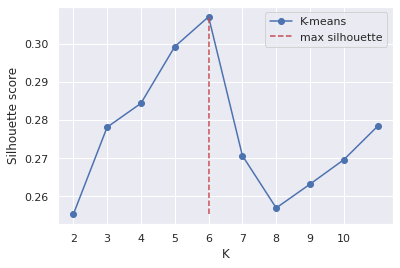

In [17]:
sil_score_0 = []
for m in models_0:
    sil_score_0.append(silhouette_score(zeroes[NUMERICAL_FEATURES], m.labels_))
    
plt.plot(CLUSTERS, sil_score_0, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_0) + 2, min(sil_score_0), max(sil_score_0), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

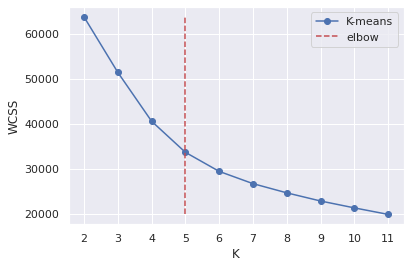

In [18]:
kl = KneeLocator(CLUSTERS, wcss_0, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_0, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_0), max(wcss_0), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

Pick $k = 5$

In [22]:
kmeans_0 = models_0[3]
print(kmeans_0)

KMeans(n_clusters=5, n_init=20, random_state=123)


In [30]:
clusters_0 = kmeans_0.predict(zeroes[NUMERICAL_FEATURES])

zeroes['Cluster'] = clusters_0

zeroes

In [41]:
zeroes['Cluster'].value_counts()

2    8803
3    5427
4    4178
0    3567
1     658
Name: Cluster, dtype: int64

## Class 1
Compute the clusters for class $1$

In [31]:
ones = df_numerical[df_numerical['Target'] == 1].copy()

In [32]:
wcss_1, models_1 = run_kmeans(ones[NUMERICAL_FEATURES])

In [33]:
for m in models_1:
    print_metrics(ones[NUMERICAL_FEATURES], m)

K=2
	SSE:		37150.38774810925
	Silhouette:		0.7969001241835686
	DaviesBouldin score:		0.2560647192018851
K=3
	SSE:		21254.271745611128
	Silhouette:		0.6033587746319867
	DaviesBouldin score:		0.4941953568760528
K=4
	SSE:		16816.139344629057
	Silhouette:		0.30347247765596697
	DaviesBouldin score:		0.9936463936829607
K=5
	SSE:		13789.572972048065
	Silhouette:		0.3178756875711479
	DaviesBouldin score:		0.9403264767486696
K=6
	SSE:		12180.671719785285
	Silhouette:		0.32950109162196806
	DaviesBouldin score:		0.9228915021564218
K=7
	SSE:		11035.897887392823
	Silhouette:		0.30585771902355596
	DaviesBouldin score:		0.9676521730211665
K=8
	SSE:		10129.200272678125
	Silhouette:		0.2864427613300817
	DaviesBouldin score:		1.0182902977182713
K=9
	SSE:		9518.804678173123
	Silhouette:		0.29312906896165103
	DaviesBouldin score:		1.0826880661658844
K=10
	SSE:		8984.522411893198
	Silhouette:		0.26285808597042515
	DaviesBouldin score:		1.205239616582261
K=11
	SSE:		8475.424912019114
	Silhouette:		0.2671133

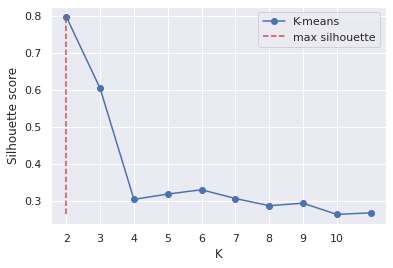

In [34]:
sil_score_1 = []
for m in models_1:
    sil_score_1.append(silhouette_score(ones[NUMERICAL_FEATURES], m.labels_))
    
plt.plot(CLUSTERS, sil_score_1, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_1) + 2, min(sil_score_1), max(sil_score_1), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 11))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

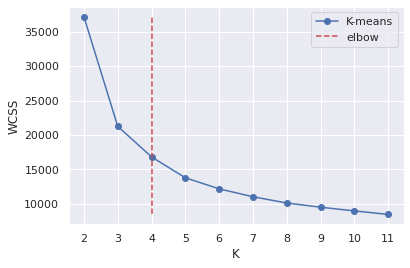

In [35]:
kl = KneeLocator(CLUSTERS, wcss_1, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_1, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_1), max(wcss_1), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

Pick $k=4$

In [38]:
kmeans_1 = models_1[2]
print(kmeans_1)

KMeans(n_clusters=4, n_init=20, random_state=123)


In [39]:
clusters_1 = kmeans_1.predict(ones[NUMERICAL_FEATURES])

ones['Cluster'] = clusters_1

ones

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Target,Cluster
7,1.032523,0.187844,-0.440434,-0.147502,-0.218673,1,2
8,-0.566720,-1.363035,1.521353,1.753432,-0.218673,1,0
9,0.270979,-0.287213,1.128996,0.551379,-0.218673,1,0
10,-0.109793,0.858146,-0.048076,-0.147502,-0.218673,1,2
11,-0.642875,-0.459014,1.128996,-0.147502,-0.218673,1,0
...,...,...,...,...,...,...,...
32538,-0.033639,-0.479051,1.128996,1.879765,-0.218673,1,0
32545,0.042516,-0.741041,0.736639,-0.147502,-0.218673,1,0
32554,1.108678,1.249989,1.521353,-0.147502,-0.218673,1,0
32557,0.118670,-0.335246,-0.440434,-0.147502,-0.218673,1,2


In [40]:
ones['Cluster'].value_counts()

0    3432
2    3191
3     735
1     148
Name: Cluster, dtype: int64

# Random Forest Creation